<a href="https://colab.research.google.com/github/sidrusiya/AILA_Tasks/blob/main/Task1_Roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov 14 08:05:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |   8386MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
# from textaugment import Wordnet, EDA, word2vec, Translate
# from nltk import WordNetLemmatizer
# from nltk.corpus import stopwords
import gensim
import re
import matplotlib.pyplot as plt
import seaborn as sns
# !pip3 install tensorflow_text
# import tensorflow_text
# !pip install -q tf-models-official
# !pip install -q -U tensorflow-text
# from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
# import tensorflow_hub as hub
# import tensorflow_text as tf_text
from tqdm import tqdm

In [ ]:
!pip3 install transformers

In [ ]:
import os
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Task1/'
list_dir = os.listdir(PATH)
text = []
labels = []
for file in list_dir:
    file_path = PATH + file
    with open(file_path, 'r') as f:
        for line in f:
            line = line.split(sep='\t')
            text.append(line[0])
            labels.append(line[1][:-1])

data = {'Text': text, "labels": labels}
dataset1 = pd.DataFrame(data=data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset1.head()

,Text,labels
0,The appellant who was arraigned as Accused 2 w...,Facts
1,"The allegations against the accused, inter ali...",Facts
2,Bindula Devi was married to Accused 1 Jaipraks...,Facts
3,The appellant and Accused 3 Shakun Devo Yadav ...,Facts
4,Accused 4 Dani Dutta Yadav is their father and...,Facts


In [ ]:
dataset1.shape

(11285, 2)

In [ ]:
dataset1.labels.value_counts()

Ratio of the decision      4211
Facts                      2622
Precedent                  1787
Argument                    939
Statute                     902
Ruling by Lower Court       483
Ruling by Present Court     341
Name: labels, dtype: int64

In [ ]:
event_types_dict = {}
for num, name in enumerate(list(dataset1['labels'].unique())):
    event_types_dict[name] = num
    # print(name, " : ", num)

event_types_dict

event_types_dict_inverse = {k:v for v,k in event_types_dict.items()}
print(event_types_dict)
print( event_types_dict_inverse)

{'Facts': 0, 'Ruling by Lower Court': 1, 'Argument': 2, 'Precedent': 3, 'Ratio of the decision': 4, 'Statute': 5, 'Ruling by Present Court': 6}
{0: 'Facts', 1: 'Ruling by Lower Court', 2: 'Argument', 3: 'Precedent', 4: 'Ratio of the decision', 5: 'Statute', 6: 'Ruling by Present Court'}


In [ ]:
def text_to_numerical_category(name):
    num = event_types_dict[name]
    return num

print(text_to_numerical_category('Facts'))
dataset1['num_labels'] = dataset1['labels'].apply(text_to_numerical_category)
dataset1

0


,Text,labels,num_labels
0,The appellant who was arraigned as Accused 2 w...,Facts,0
1,"The allegations against the accused, inter ali...",Facts,0
2,Bindula Devi was married to Accused 1 Jaipraks...,Facts,0
3,The appellant and Accused 3 Shakun Devo Yadav ...,Facts,0
4,Accused 4 Dani Dutta Yadav is their father and...,Facts,0
...,...,...,...
11280,"Suffice it to state that the appellant,as a fa...",Ratio of the decision,4
11281,"The High Court,in our view,declined,for good r...",Ratio of the decision,4
11282,We are also not persuaded to take a different ...,Ratio of the decision,4
11283,"In these circumstances,we are of the view that...",Ratio of the decision,4


In [ ]:
# Remove Excess [Size:: ] from EoS
def remove_size(text):
	result = re.search("\[size", text)
	if result is not None:
		text = text[:result.start()]
	return text.strip()

months = ['january', 'jan', 'feb', 'mar', 'apr', 'aug', 'sept', 'oct', 'nov', 'dec', 'feburary', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'on']
def remove_months(text):
    text = text.split()
    text = [word for word in text if word.lower() not in set(months)]
    text = ' '.join(text)
    return text

def remove_nums(text):
    result = re.sub(r'[0-9+]', '', text)
    return result

def remove_comma(text):
    result = re.sub(r',', '', text)
    return result

In [ ]:
import sys
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
text = []
lem_text = []
for i in dataset1.index:
    dataset1['Text'][i] = remove_size(dataset1['Text'][i])
    dataset1['Text'][i] = remove_months(dataset1['Text'][i])
    dataset1['Text'][i] = remove_nums(dataset1['Text'][i])
    dataset1['Text'][i] = remove_comma(dataset1['Text'][i])
    temp = dataset1['Text'][i].lower().split()
    clean = [word for word in temp if word not in stopwords.words('english')]
    clean = " ".join(clean)
    text.append(clean)
    lem_text.append(clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dis

In [ ]:
for i in range(len(text)):
    text[i] = text[i].split()

In [ ]:
for i in range(len(lem_text)):
    lem_text[i] = lem_text[i].split()

In [ ]:
from nltk import PorterStemmer
st = PorterStemmer()
for i in range(len(text)):
    text[i] = [st.stem(word) for word in text[i]]

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

for i in range(len(lem_text)):
    lem_text[i] = [lemmatizer.lemmatize(word) for word in lem_text[i]]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
for i in range(len(text)):
    text[i] = " ".join(text[i])

text[0]

'appel arraign accus tri along five accus offenc punish section read ss. ipc st addit session judg madhepura.'

In [ ]:
for i in range(len(lem_text)):
    lem_text[i] = " ".join(lem_text[i])

lem_text[0]

'appellant arraigned accused tried along five accused offence punishable section read ss. ipc st additional session judge madhepura.'

In [ ]:
dataset1['lem_text'] = np.array(lem_text)
dataset1['stem_text'] = np.array(text)

dataset1

,Text,labels,num_labels,lem_text,stem_text
0,The appellant who was arraigned as Accused wa...,Facts,0,appellant arraigned accused tried along five a...,appel arraign accus tri along five accus offen...
1,The allegations against the accused inter alia...,Facts,0,allegation accused inter alia subjected one bi...,alleg accus inter alia subject one bindula dev...
2,Bindula Devi was married to Accused Jaipraksh...,Facts,0,bindula devi married accused jaipraksh yadav.,bindula devi marri accus jaipraksh yadav.
3,The appellant and Accused Shakun Devo Yadav a...,Facts,0,appellant accused shakun devo yadav brother ac...,appel accus shakun devo yadav brother accus ja...
4,Accused Dani Dutta Yadav is their father and ...,Facts,0,accused dani dutta yadav father accused satya ...,accus dani dutta yadav father accus satya bham...
...,...,...,...,...,...
11280,Suffice it to state that the appellantas a fac...,Ratio of the decision,4,suffice state appellantas facthad used trade m...,suffic state appellanta facthad use trade mark...
11281,The High Courtin our viewdeclinedfor good reas...,Ratio of the decision,4,high courtin viewdeclinedfor good reasonsto re...,high courtin viewdeclinedfor good reasonsto re...
11282,We are also not persuaded to take a different ...,Ratio of the decision,4,also persuaded take different view high court,also persuad take differ view high court
11283,In these circumstanceswe are of the view that ...,Ratio of the decision,4,circumstanceswe view high court properly exerc...,circumstancesw view high court properli exerci...


In [ ]:
dataset1.labels.value_counts()

Ratio of the decision      4211
Facts                      2622
Precedent                  1787
Argument                    939
Statute                     902
Ruling by Lower Court       483
Ruling by Present Court     341
Name: labels, dtype: int64

In [ ]:
dataset1.drop_duplicates(['lem_text']).labels.value_counts()

Ratio of the decision      4146
Facts                      2566
Precedent                  1754
Argument                    905
Statute                     867
Ruling by Lower Court       476
Ruling by Present Court     276
Name: labels, dtype: int64

In [ ]:
from sklearn.utils import shuffle

lemm = []
labels = []
THRESH_1 = 1500
THRESH_2 = 500

for group in dataset1.labels.unique():
    if len(dataset1.groupby('labels').get_group(group).lem_text.unique()) > THRESH_1:
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        labels += ([group]*2*len(list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique()))))

    elif len(dataset1.groupby('labels').get_group(group).lem_text.unique()) > THRESH_2:
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        labels += ([group]*3*len(list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique()))))
    else:
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        labels += ([group]*5*len(list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique()))))

In [ ]:
balanced_df = pd.DataFrame({'Text' : lemm, 'Labels': labels})

In [ ]:
balanced_df.Labels.value_counts()

Ratio of the decision      8328
Facts                      5164
Precedent                  3528
Argument                   2754
Statute                    2619
Ruling by Lower Court      2410
Ruling by Present Court    1395
Name: Labels, dtype: int64

In [ ]:
balanced_df['NumLabel'] = balanced_df.Labels.apply(text_to_numerical_category)

In [ ]:
balanced_df.head()

,Text,Labels,NumLabel
0,may society purchased land admeasuring acre gu...,Facts,0
1,registrar,Facts,0
2,"meghraj"".in rectification application",Facts,0
3,case negatived industrial court well labour ap...,Facts,0
4,pw-,Facts,0


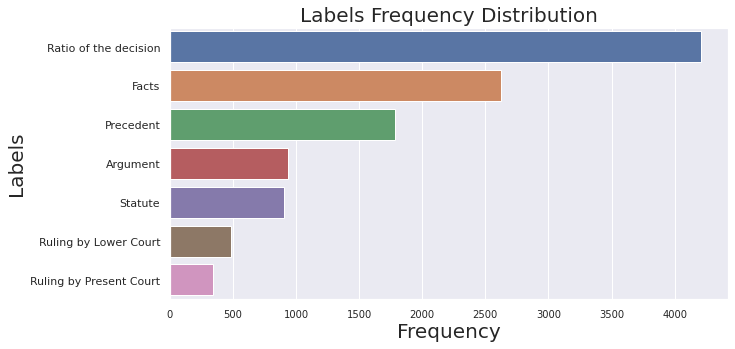

In [ ]:
sns.set_theme(style="darkgrid")
x = dataset1['labels'].value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Labels Frequency Distribution", fontsize=20)
plt.ylabel('Labels', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

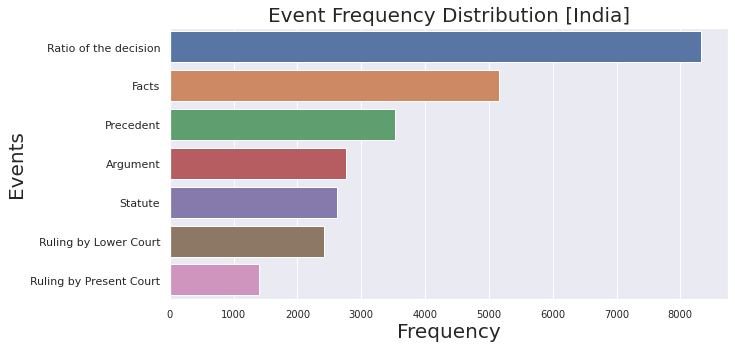

In [ ]:
sns.set_theme(style="darkgrid")
x = balanced_df.Labels.value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Event Frequency Distribution [India]", fontsize=20)
plt.ylabel('Events', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

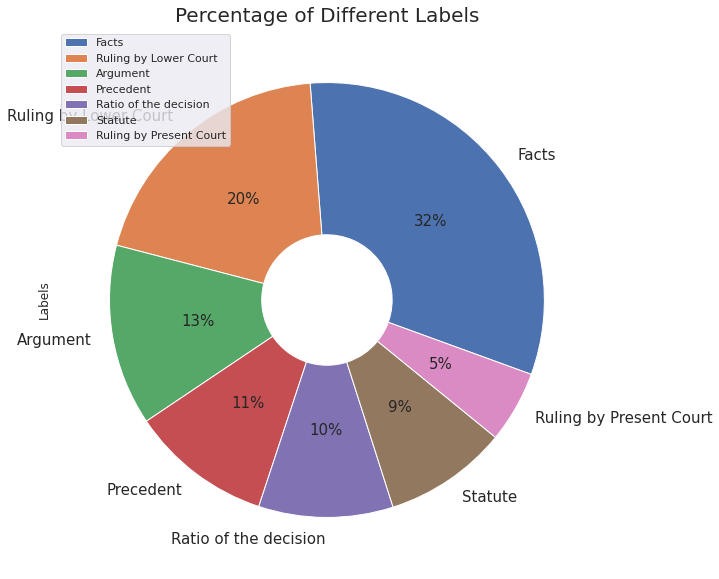

In [ ]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Different Labels', fontsize=20)
balanced_df.Labels.value_counts().plot(kind='pie', labels= balanced_df.Labels.unique(),
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.legend(loc='upper left')
plt.show()

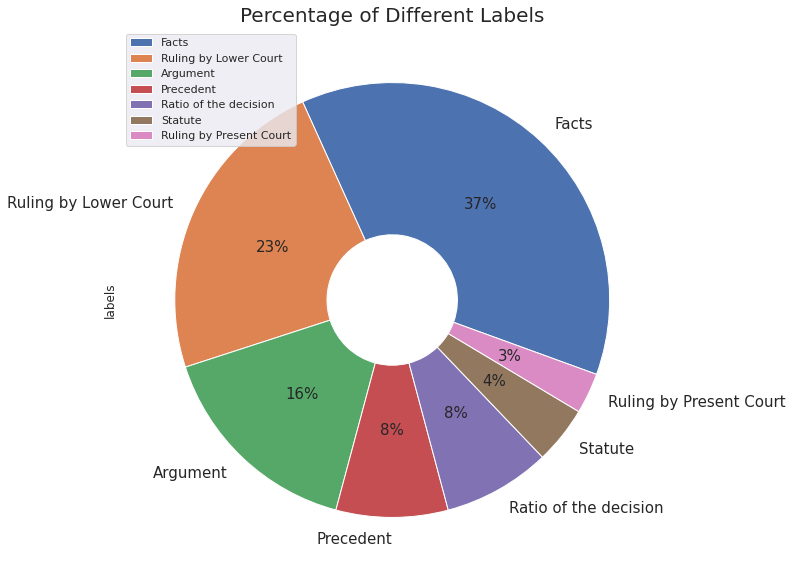

In [ ]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Different Labels', fontsize=20)
dataset1.labels.value_counts().plot(kind='pie', labels= dataset1.labels.unique(),
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.legend(loc='upper left')
plt.show()

In [ ]:
max_classes = len(balanced_df.Labels.unique())
max_length=128

In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# Same as before
checkpoint = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(checkpoint, max_length=max_length)

In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

EPOCHS = 5
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
batch_size = 32

# num_train_steps =  len((balanced_df.NumLabel) // batch_size) * EPOCHS
# lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5,
#                                end_learning_rate=0.,
#                                decay_steps=num_train_steps
#                                )

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=5e-5)

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
result_df = shuffle(balanced_df)

In [ ]:
result_df

,Text,Labels,NumLabel
3181,year andhra engineering co. originally partner...,Facts,0
752,ranganayaki entered possession property death ...,Facts,0
20410,penal provision ultimately social legislations...,Ratio of the decision,4
24136,part xvii [$] constitution deal official langu...,Statute,5
15897,learned judge special court shall take matter ...,Ratio of the decision,4
...,...,...,...
8268,anticipation acquisition execution work appoin...,Argument,2
25846,determination liability adjustment due payable...,Ruling by Present Court,6
6011,case court upheld order high court madras quas...,Ruling by Lower Court,1
4963,appellant bhumidar transferable right resident...,Facts,0


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(result_df.Text, result_df.NumLabel, test_size = 0.1, random_state = 42, stratify =result_df.NumLabel)

In [ ]:
max_classes = len(balanced_df.Labels.unique())
print(max_classes)

7


In [ ]:
%%time
encoded_labels_train = to_categorical(Y_train, num_classes=max_classes)
encoded_labels_test = to_categorical(Y_test, num_classes=max_classes)

CPU times: user 2.05 ms, sys: 0 ns, total: 2.05 ms
Wall time: 1.42 ms


In [ ]:
def roberta_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in tqdm(range(len(data))):
      encoded = tokenizer.encode_plus(
        
        data[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [ ]:
%%time
train_inputs,train_attention_masks = roberta_encode(list(X_train), max_length)

  0%|          | 0/23578 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 23578/23578 [00:10<00:00, 2237.83it/s]


CPU times: user 11 s, sys: 55.8 ms, total: 11.1 s
Wall time: 11.1 s


In [ ]:
test_inputs,test_attention_masks = roberta_encode(list(X_test), max_length)

  0%|          | 0/2620 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 2620/2620 [00:01<00:00, 2530.04it/s]


In [ ]:
print(f'Number of Samples in Training Set : {len(X_train)} Number of Samples in Validation Set: {len(X_test)} ')

Number of Samples in Training Set : 23578 Number of Samples in Validation Set: 2620 


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!mkdir checkpoints
filepath = "RoBERT-lemm-{epoch:02d}.h5"
MyCheckpoint = ModelCheckpoint(filepath,
                               monitor = 'val_categorical_accuracy',
                               verbose = 1,
                               save_best_only = True,
                               mode='auto',
                               save_weights_only = True)

MyEarlyStopping = EarlyStopping(patience =1,
                                monitor='val_categorical_accuracy',
                                restore_best_weights = True,
                                verbose = 1)

ModelSaver = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

mkdir: cannot create directory ‘checkpoints’: File exists


In [ ]:
from sklearn.utils import class_weight
class_weights_array = class_weight.compute_class_weight('balanced'
                                               ,np.unique(balanced_df.NumLabel)
                                               ,balanced_df.NumLabel)

class_weights_array

array([0.72474272, 1.5529342 , 1.3589584 , 1.06081957, 0.44939618,
       1.4290078 , 2.6828469 ])

In [ ]:
class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
class_weights

{0: 0.7247427243554276,
 1: 1.5529342027267339,
 2: 1.3589583981740845,
 3: 1.0608195659216066,
 4: 0.4493961849869631,
 5: 1.4290078001418207,
 6: 2.682846902201741}

In [ ]:
# !pip install tensorflow_addons
# import tensorflow_addons as tfa

# macro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='macro')
# micro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='micro')
# weighted_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='weighted')
precision = tf.metrics.Precision()
recall = tf.metrics.Recall()
categorical_accuracry = tf.metrics.CategoricalAccuracy()

class F1_metric(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        # Initialize our metric by initializing the two metrics it's based on:
        # Precision and Recall
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update our metric by updating the two metrics it's based on
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
        # To get the F1 result, we compute the harmonic mean of the current
        # precision and recall
        return 2 / ((1 / self.precision.result()) + (1 / self.recall.result())) 

F1Score = F1_metric()
metrics = [categorical_accuracry, F1Score]


In [ ]:
def create_model(roberta_model):
  input_ids = tf.keras.Input(shape=(max_length,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(max_length,),dtype='int32')
  
  output = roberta_model([input_ids,attention_masks])
  output = output[1]
  
#   output = tf.keras.layers.Dense(128,activation='relu',)(output)
#   output = tf.keras.layers.Dropout(0.2)(output)
#   output = tf.keras.layers.BatchNormalization()(output)

#   output = tf.keras.layers.Dense(64,activation='relu',)(output)
#   output = tf.keras.layers.Dropout(0.2)(output)
#   output = tf.keras.layers.BatchNormalization()(output)

  output = tf.keras.layers.Dense(32,activation='relu')(output)
  output = tf.keras.layers.Dropout(0.2)(output)
  
  output = tf.keras.layers.Dense(units=max_classes,activation='softmax')(output)
  model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
  model.compile(optimizer= opt,
              loss= loss,
              metrics = metrics)
  return model

In [ ]:
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

model = create_model(roberta_model)
model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_3[0][0]',                
 odel)                          thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [ ]:
%%time
history = model.fit([train_inputs,train_attention_masks], encoded_labels_train, 
                    validation_data=([test_inputs, test_attention_masks], encoded_labels_test),
                    epochs = EPOCHS,
                    batch_size = 32,
                    verbose = 1,
                    class_weight=class_weights,
                    callbacks = [MyCheckpoint, MyEarlyStopping]
                    )

Epoch 1/5
737/737 [==============================] - ETA: 0s - loss: 1.7023 - categorical_accuracy: 0.2817 - f1_score: 0.1261
Epoch 00001: val_categorical_accuracy improved from -inf to 0.47672, saving model to RoBERT-lemm-01.h5
737/737 [==============================] - 1183s 2s/step - loss: 1.7023 - categorical_accuracy: 0.2817 - f1_score: 0.1261 - val_loss: 1.4589 - val_categorical_accuracy: 0.4767 - val_f1_score: 0.3472
Epoch 2/5
737/737 [==============================] - ETA: 0s - loss: 1.1388 - categorical_accuracy: 0.5339 - f1_score: 0.4363
Epoch 00002: val_categorical_accuracy improved from 0.47672 to 0.61336, saving model to RoBERT-lemm-02.h5
737/737 [==============================] - 1160s 2s/step - loss: 1.1388 - categorical_accuracy: 0.5339 - f1_score: 0.4363 - val_loss: 1.0988 - val_categorical_accuracy: 0.6134 - val_f1_score: 0.5642
Epoch 3/5
737/737 [==============================] - ETA: 0s - loss: 0.7747 - categorical_accuracy: 0.6585 - f1_score: 0.6179
Epoch 00003: va

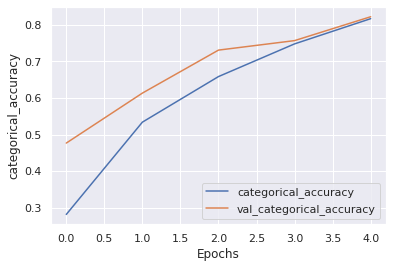

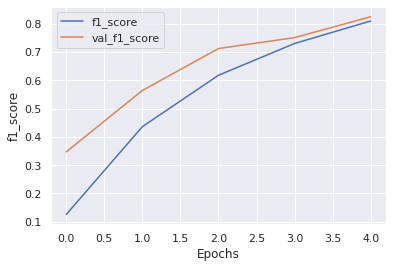

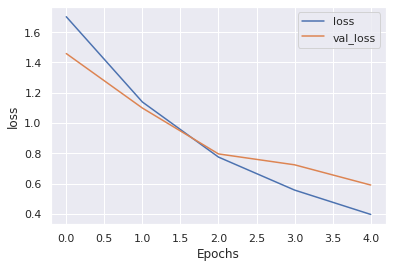

In [ ]:
import matplotlib.pyplot as plt 
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "categorical_accuracy")
plot_graphs(history, "f1_score")
plot_graphs(history, 'loss')

In [ ]:
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Task1_Test/'
list_dir = os.listdir(PATH)
text = []
labels = []
sentid = []
i=0
for file in list_dir:
    file_path = PATH + file
    j=1
    i=i+1
    with open(file_path, 'r') as f:
        for line in f:
            line = line.split(sep='\t')
            text.append(line[0])
            labels.append(line[1][:-1])
            sentid.append("d"+str(i)+"_s"+str(j))
            j=j+1

data = {'ID': sentid, 'Text': text, "labels": labels}
test_file = pd.DataFrame(data=data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 # Remove Excess [Size:: ] from EoS
def remove_size(text):
	result = re.search("\[size", text)
	if result is not None:
		text = text[:result.start()]
	return text.strip()

months = ['january', 'jan', 'feb', 'mar', 'apr', 'aug', 'sept', 'oct', 'nov', 'dec', 'feburary', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'on']
def remove_months(text):
    text = text.split()
    text = [word for word in text if word.lower() not in set(months)]
    text = ' '.join(text)
    return text

def remove_nums(text):
    result = re.sub(r'[0-9+]', '', text)
    return result

def remove_comma(text):
    result = re.sub(r',', '', text)
    return result

In [ ]:
def text_cleaning(text):
    text = remove_size(text)
    text = remove_nums(text)
    text = remove_months(text)
    text = remove_comma(text)
    return text.strip().lower()

test_file['processed'] = test_file['Text'].apply(text_cleaning)

In [ ]:
test_file.head()

,ID,Text,labels,processed
0,d1_s1,These two Criminal Appeals are preferred by th...,Facts,these two criminal appeals are preferred by th...
1,d1_s2,Application no. 1295 of 2011 and 1296 of 2011 ...,Facts,application no. of and of passed by the learne...
2,d1_s3,"The respondent no. 1 Shyam Vithalrao Devkatta,...",Facts,the respondent no. shyam vithalrao devkatta fi...
3,d1_s4,Upon due verification process was issued by th...,Facts,upon due verification process was issued by th...
4,d1_s5,"Of these accused, four approached the Bombay H...",Facts,of these accused four approached the bombay hi...


In [ ]:
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('punkt')
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
def lemmatizing_headlines(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]
    return ' '.join(tokens).strip()

test_file['processed'] = test_file['processed'].apply(lemmatizing_headlines)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
test_file

,ID,Text,labels,processed
0,d1_s1,These two Criminal Appeals are preferred by th...,Facts,two criminal appeal preferred accused judgment...
1,d1_s2,Application no. 1295 of 2011 and 1296 of 2011 ...,Facts,application . passed learned single judge bomb...
2,d1_s3,"The respondent no. 1 Shyam Vithalrao Devkatta,...",Facts,respondent . shyam vithalrao devkatta filed co...
3,d1_s4,Upon due verification process was issued by th...,Facts,upon due verification process issued learned m...
4,d1_s5,"Of these accused, four approached the Bombay H...",Facts,accused four approached bombay high court way ...
...,...,...,...,...
692,d10_s60,"Applying the above principles, it is clear fro...",Ratio of the decision,applying principle clear finding two court cir...
693,d10_s61,Kalawati was last seen in the company of the a...,Ratio of the decision,kalawati last seen company appellant gher even...
694,d10_s62,"After his arrest, the production, by the appel...",Ratio of the decision,arrest production appellant ornament worn kala...
695,d10_s63,"To conclude, the appellant has been rightly co...",Ruling by Present Court,conclude appellant rightly convicted sentenced...


  0%|          | 0/697 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 697/697 [00:00<00:00, 2186.34it/s]


[0 0 0 0 0 0 0 0 2 6 0 2 0 0 2 0 4 0 0 0 2 0 0 2 3 2 0 2 0 0 5 5 5 5 0 0 0
 4 0 4 4 4 4 4 4 5 0 5 0 4 4 4 4 4 4 4 2 3 3 4 6 4 3 3 1 0 2 4 4 4 4 3 4 4
 4 4 3 3 3 6 0 4 2 3 0 4 4 3 3 6 2 5 4 4 4 2 3 4 3 4 4 4 6 3 4 4 2 1 2 0 6
 6 6 0 5 0 0 0 1 0 1 0 2 4 0 2 0 2 0 2 2 2 2 2 2 2 3 2 3 2 2 2 2 4 2 6 2 2
 2 4 4 0 0 0 0 0 1 0 6 0 2 1 5 0 4 5 5 5 5 4 5 5 5 5 4 4 4 5 5 5 5 5 2 4 4
 0 2 4 4 4 0 0 0 0 3 4 6 6 6 0 4 0 6 0 2 0 2 2 6 6 6 1 0 0 0 0 2 0 2 0 2 0
 2 0 0 0 0 0 0 0 2 0 6 3 0 0 4 0 1 4 4 0 3 6 4 5 5 5 5 0 2 5 5 5 0 6 1 6 6
 6 0 2 1 1 2 6 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 4 0 0 0 0 0 0 4 4 6 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 1 4 0 0 0 0 0 2 2 0 0
 6 6 3 0 6 6 6 0 6 6 1 0 0 0 0 2 6 0 0 2 0 2 4 2 4 6 1 0 0 6 1 6 0 2 2 2 2
 2 2 2 0 0 0 5 6 0 6 0 0 0 0 1 6 0 0 3 3 5 0 0 4 2 0 0 3 6 6 6 1 2 0 0 2 6
 1 4 6 0 1 0 6 0 3 2 2 0 4 4 3 4 6 2 6 5 3 5 4 0 4 0 4 6 3 3 0 6 6 6 2 0 0
 0 0 0 0 0 0 0 2 2 2 0 2 1 0 2 2 0 4 1 4 6 0 4 2 0 0 1 4 0 6 0 6 6 6 2 6 6
 6 1 6 6 6 0 0 0 0 0 2 2 

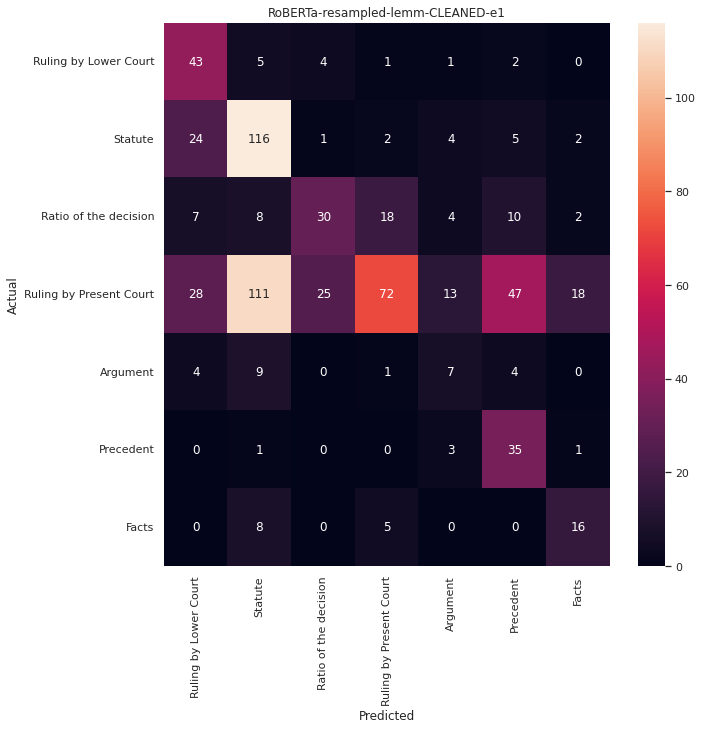

In [ ]:
model.load_weights('./RoBERT-lemm-01.h5')
final_test_inputs, final_test_attention_masks = roberta_encode(list(test_file.processed), max_length)
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

test_file['pred-labels-cleaned-e1'] = y_preds
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

print(y_preds)
test_file['pred-labels-cleaned-e1'] = test_file['pred-labels-cleaned-e1'].apply(num_to_text_labels)


from sklearn.metrics import classification_report

print(classification_report(y_true= list(test_file.labels), y_pred= list(test_file['pred-labels-cleaned-e1'])))

import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(test_file.labels), list(test_file['pred-labels-cleaned-e1']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.labels), yticklabels=set(test_file.labels))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('RoBERTa-resampled-lemm-CLEANED-e1')
plt.show()

  0%|          | 0/697 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 697/697 [00:00<00:00, 2347.10it/s]


[0 0 0 0 0 0 0 0 0 4 0 0 1 0 0 0 4 0 1 1 1 1 0 2 2 2 0 2 0 4 5 5 5 5 1 5 0
 3 0 4 5 5 5 4 3 5 4 5 5 4 3 3 3 4 5 4 4 3 1 3 4 4 3 3 1 0 2 4 3 3 5 3 1 3
 3 1 4 3 3 1 5 3 2 3 3 3 3 0 1 1 2 5 3 5 5 1 3 5 5 3 3 5 4 5 3 4 2 4 2 4 6
 6 6 0 1 0 0 0 0 0 0 0 2 4 0 2 0 2 0 2 2 2 0 2 2 2 3 2 2 2 2 2 3 5 2 3 2 2
 2 4 5 0 1 0 0 0 4 0 6 0 2 0 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 4 4
 1 0 0 4 4 0 0 1 4 3 4 3 6 1 0 3 0 1 0 0 0 0 4 6 6 6 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 4 4 3 2 0 1 0 4 4 4 3 3 3 4 5 5 5 5 4 2 5 5 5 0 3 1 6 6
 6 0 0 1 1 0 1 0 0 0 0 0 2 0 0 4 1 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 3 1 4 0 0 0 0 4 0 1 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 1 4 0 0 0 0 0 2 2 1 0
 1 3 3 1 6 0 6 1 6 6 0 0 4 0 0 0 3 0 0 0 4 0 5 0 6 4 1 1 4 3 1 1 0 2 2 2 2
 2 2 4 1 0 1 5 3 0 1 0 0 1 4 1 4 0 4 3 3 3 5 0 4 0 4 4 3 6 6 6 0 0 0 4 2 1
 1 4 0 1 0 0 3 0 2 2 2 4 4 4 3 4 6 0 3 5 3 5 4 0 0 3 4 1 3 3 1 1 6 6 4 0 0
 0 0 0 0 0 0 0 0 0 2 0 1 1 1 0 0 0 4 1 1 3 0 4 1 0 4 1 1 1 1 3 1 1 6 2 6 4
 6 1 3 6 6 0 0 1 0 0 1 1 

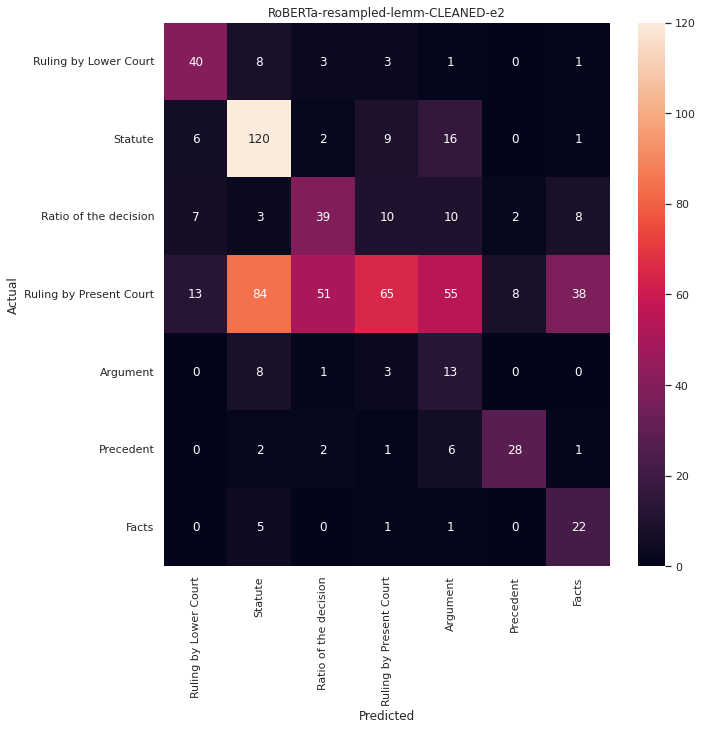

In [ ]:
model.load_weights('./RoBERT-lemm-02.h5')
final_test_inputs, final_test_attention_masks = roberta_encode(list(test_file.processed), max_length)
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

test_file['pred-labels-cleaned-e2'] = y_preds
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

print(y_preds)
test_file['pred-labels-cleaned-e2'] = test_file['pred-labels-cleaned-e2'].apply(num_to_text_labels)


from sklearn.metrics import classification_report

print(classification_report(y_true= list(test_file.labels), y_pred= list(test_file['pred-labels-cleaned-e2'])))

import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(test_file.labels), list(test_file['pred-labels-cleaned-e2']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.labels), yticklabels=set(test_file.labels))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('RoBERTa-resampled-lemm-CLEANED-e2')
plt.show()

  0%|          | 0/697 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 697/697 [00:00<00:00, 2612.06it/s]


[0 4 0 0 0 0 0 0 5 4 0 4 4 0 0 0 4 0 4 0 4 0 4 2 2 2 0 2 4 4 5 5 5 5 5 5 0
 4 4 4 4 3 3 4 3 5 3 4 4 4 3 4 3 3 5 4 4 3 3 3 4 4 5 3 3 4 2 3 3 3 5 3 3 3
 3 4 3 3 3 3 3 3 0 3 3 3 3 0 0 1 2 5 3 5 3 0 3 5 3 3 3 3 4 3 4 4 2 4 2 4 6
 0 6 0 4 0 0 0 0 0 0 0 0 4 2 2 0 2 4 2 2 2 4 2 2 2 3 2 2 2 2 2 3 3 4 4 2 2
 2 4 5 0 0 0 0 4 4 0 3 0 2 0 5 3 5 5 5 5 5 4 5 5 5 5 3 5 5 5 5 5 5 5 3 4 4
 0 0 3 4 4 4 4 4 4 3 3 3 3 6 0 4 4 3 4 0 4 4 4 1 6 6 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 4 4 3 4 4 4 0 0 4 4 3 4 3 4 5 5 5 5 4 2 5 5 5 4 4 4 6 6
 6 0 0 1 1 0 1 4 4 0 0 0 4 0 0 4 0 4 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 3 2 4 0 0 4 0 4 4 4 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 4 0 0 4 4 4 2 2 4 0
 3 3 3 0 1 4 6 0 6 6 0 0 4 0 0 4 3 4 4 4 4 4 5 0 4 4 0 0 4 4 1 1 0 2 4 2 2
 2 2 4 0 4 0 5 4 0 3 0 4 5 4 4 4 0 4 3 3 5 5 4 4 4 4 4 4 1 6 6 0 0 5 4 4 4
 0 4 0 0 0 0 4 0 2 2 2 4 4 4 4 4 1 4 3 5 3 0 5 0 4 3 4 4 3 3 4 6 6 6 4 0 0
 0 0 4 0 0 4 0 2 0 2 0 0 1 0 0 0 0 3 4 4 3 0 4 1 4 4 1 4 0 4 4 4 4 4 2 6 4
 6 4 3 6 6 0 0 0 0 0 0 4 

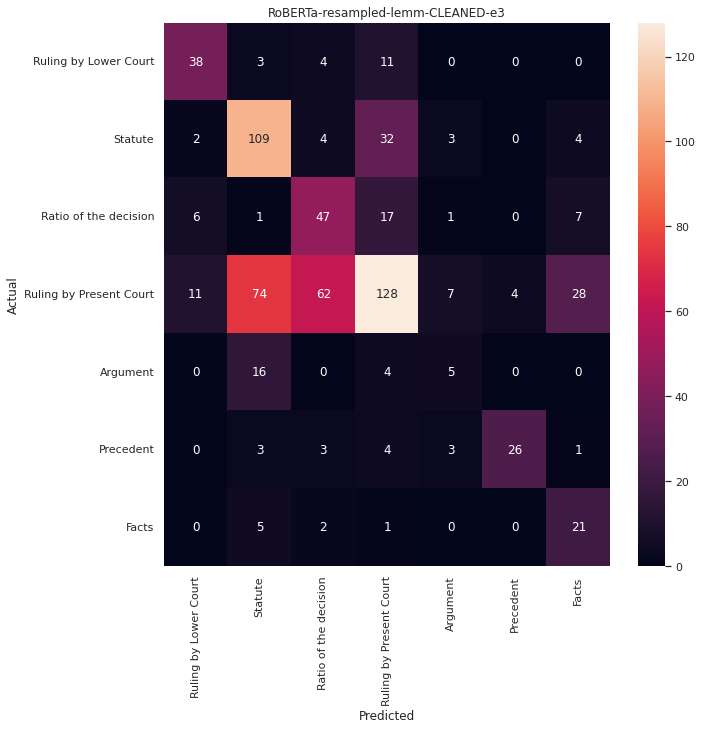

In [ ]:
model.load_weights('./RoBERT-lemm-03.h5')
final_test_inputs, final_test_attention_masks = roberta_encode(list(test_file.processed), max_length)
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

test_file['pred-labels-cleaned-e3'] = y_preds
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

print(y_preds)
test_file['pred-labels-cleaned-e3'] = test_file['pred-labels-cleaned-e3'].apply(num_to_text_labels)


from sklearn.metrics import classification_report

print(classification_report(y_true= list(test_file.labels), y_pred= list(test_file['pred-labels-cleaned-e3'])))

import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(test_file.labels), list(test_file['pred-labels-cleaned-e3']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.labels), yticklabels=set(test_file.labels))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('RoBERTa-resampled-lemm-CLEANED-e3')
plt.show()

  0%|          | 0/697 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 697/697 [00:00<00:00, 2534.68it/s]


[0 0 0 1 0 1 0 0 4 4 0 0 0 0 0 0 4 0 1 3 4 1 1 2 2 2 0 2 0 4 5 5 5 5 0 0 0
 4 4 4 3 3 3 4 3 5 3 3 4 4 3 4 4 3 4 4 4 3 3 3 3 2 3 3 3 4 2 4 3 3 3 3 3 3
 4 4 4 3 3 3 3 3 3 3 3 3 3 3 0 1 2 0 4 4 3 3 3 3 3 3 3 3 1 3 3 4 2 4 2 4 6
 1 6 0 0 0 0 0 1 0 6 0 2 4 2 2 0 2 0 2 2 2 0 2 2 2 3 2 2 2 2 2 6 3 3 1 2 2
 2 4 5 0 0 0 0 0 6 0 3 0 2 0 5 6 4 5 5 5 5 5 5 5 5 5 4 5 0 5 5 5 5 5 3 4 3
 3 0 3 0 4 2 4 3 4 3 3 3 3 1 0 4 0 4 0 0 0 0 6 6 6 6 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 4 3 3 4 4 4 0 0 4 4 3 3 3 4 5 5 5 3 4 2 0 5 5 4 3 3 6 6
 6 1 0 1 1 0 1 0 0 0 0 0 4 0 0 0 1 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0
 3 4 4 0 0 4 0 4 0 4 0 0 0 0 0 0 0 0 4 0 0 0 0 4 0 0 1 4 0 0 0 0 0 2 2 4 0
 1 3 4 1 1 1 6 0 6 6 0 0 4 0 0 3 3 0 0 0 4 0 5 0 4 4 2 1 4 4 1 1 1 2 0 2 2
 2 2 0 1 0 0 5 4 0 3 0 0 1 4 4 4 0 4 3 3 4 0 4 4 0 4 0 4 1 6 6 0 1 5 0 2 4
 1 4 0 1 0 1 4 0 3 2 2 3 4 0 0 4 6 0 4 5 3 0 4 0 0 4 0 0 3 3 1 6 6 6 4 0 0
 0 0 0 0 0 4 0 0 0 2 0 0 1 1 1 0 0 3 0 3 3 0 4 1 0 0 1 4 1 1 4 1 6 1 2 6 4
 6 6 3 6 6 0 0 0 0 0 1 0 

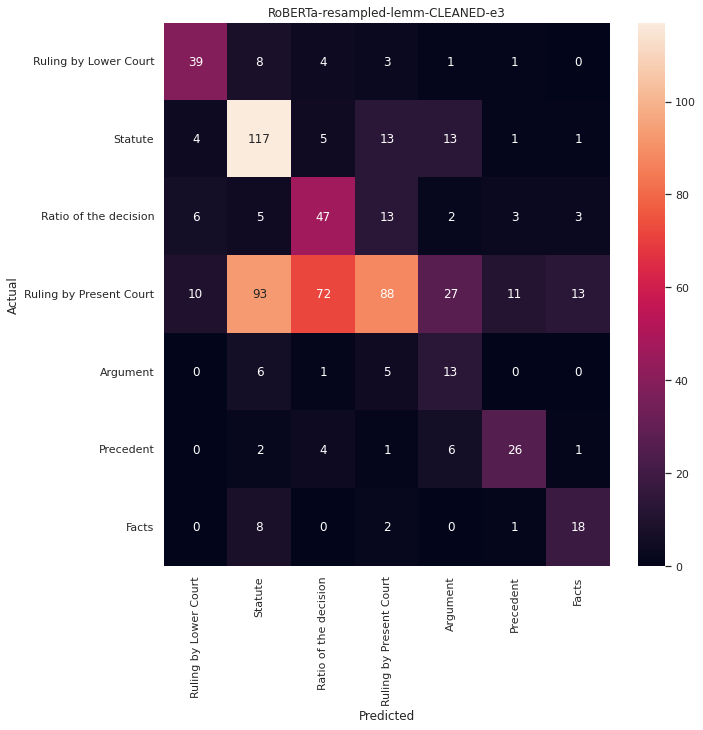

In [ ]:
model.load_weights('./RoBERT-lemm-04.h5')
final_test_inputs, final_test_attention_masks = roberta_encode(list(test_file.processed), max_length)
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

test_file['pred-labels-cleaned-e3'] = y_preds
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

print(y_preds)
test_file['pred-labels-cleaned-e3'] = test_file['pred-labels-cleaned-e3'].apply(num_to_text_labels)


from sklearn.metrics import classification_report

print(classification_report(y_true= list(test_file.labels), y_pred= list(test_file['pred-labels-cleaned-e3'])))

import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(test_file.labels), list(test_file['pred-labels-cleaned-e3']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.labels), yticklabels=set(test_file.labels))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('RoBERTa-resampled-lemm-CLEANED-e3')
plt.show()

  0%|          | 0/697 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 697/697 [00:00<00:00, 2653.84it/s]


[0 0 0 0 0 0 4 0 5 4 0 3 4 0 0 0 4 0 3 3 4 1 4 2 4 2 0 2 0 4 5 5 5 5 5 5 4
 4 4 4 3 3 3 4 3 5 4 3 4 3 4 4 4 3 5 4 4 3 3 3 3 3 5 3 3 4 2 5 4 5 3 3 3 3
 3 3 3 3 3 3 4 3 0 3 3 3 3 0 3 1 2 4 3 3 3 3 4 5 3 3 3 3 1 3 3 4 2 4 2 4 1
 1 6 0 0 0 0 0 1 0 1 0 2 3 2 2 5 2 4 2 2 2 4 2 2 2 3 2 2 2 2 2 3 4 4 3 2 2
 2 4 5 0 0 4 0 0 3 0 3 0 2 0 5 3 5 5 5 5 5 4 5 5 5 5 4 5 5 5 5 5 5 5 2 4 3
 3 0 3 4 4 2 4 4 4 3 3 3 3 6 0 3 4 4 0 0 0 0 4 1 6 6 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 3 4 3 3 3 4 4 0 0 4 4 3 3 3 4 5 5 5 5 4 2 5 5 5 4 4 5 6 6
 1 1 0 1 1 0 1 0 0 0 3 4 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0
 3 4 4 0 0 4 0 3 3 4 0 0 0 0 4 0 0 0 4 0 0 0 0 0 0 4 0 4 0 0 4 4 4 2 2 4 0
 1 3 3 1 1 1 1 0 1 1 1 0 5 0 0 3 3 5 4 0 4 4 5 0 4 4 0 0 4 4 1 1 1 2 4 2 0
 2 2 4 1 4 0 5 4 0 3 0 4 5 4 1 4 0 4 3 3 4 5 4 4 0 4 4 4 6 1 6 0 1 5 4 2 4
 1 4 0 0 0 1 4 4 3 2 2 4 4 4 4 4 1 0 4 5 1 0 4 0 1 4 4 4 3 3 4 1 6 6 4 0 0
 0 0 0 0 0 4 0 0 5 2 0 1 1 1 1 0 0 3 1 3 3 0 4 1 4 4 1 1 0 4 4 4 1 1 4 1 4
 1 5 3 6 6 0 0 0 0 0 1 0 

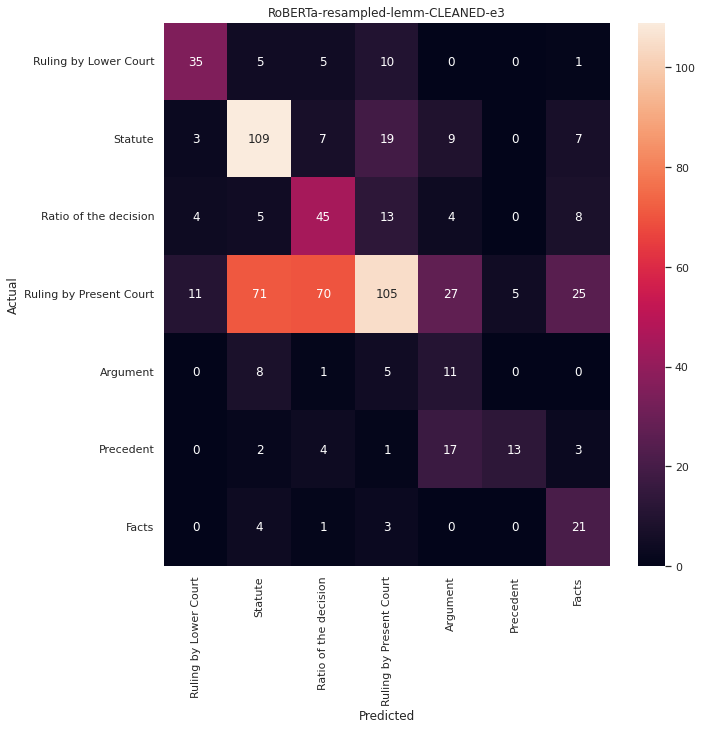

In [ ]:
model.load_weights('./RoBERT-lemm-05.h5')
final_test_inputs, final_test_attention_masks = roberta_encode(list(test_file.processed), max_length)
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

test_file['pred-labels-cleaned-e3'] = y_preds
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

print(y_preds)
test_file['pred-labels-cleaned-e3'] = test_file['pred-labels-cleaned-e3'].apply(num_to_text_labels)


from sklearn.metrics import classification_report

print(classification_report(y_true= list(test_file.labels), y_pred= list(test_file['pred-labels-cleaned-e3'])))

import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(test_file.labels), list(test_file['pred-labels-cleaned-e3']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.labels), yticklabels=set(test_file.labels))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('RoBERTa-resampled-lemm-CLEANED-e3')
plt.show()